In [1]:
from fastai import *
from fastai.basics import *

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [3]:
path = Config().data_path()/'mnist'

In [4]:
path.mkdir(parents=True)

In [5]:
path.ls()

[]

In [6]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz -P {path}

--2019-07-02 09:13:16--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘/tmp/.fastai/data/mnist/mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  15.9MB/s    in 1.0s    

2019-07-02 09:13:17 (15.9 MB/s) - ‘/tmp/.fastai/data/mnist/mnist.pkl.gz’ saved [16168813/16168813]



In [7]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid,y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

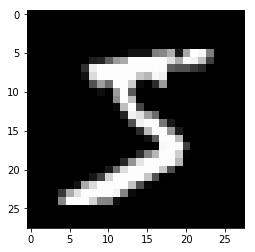

In [8]:
plt.imshow(x_train[0].reshape((28,28)), cmap='gray')
x_train.shape

In [9]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [10]:
bs=64
train_ds = TensorDataset(x_train,y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs)

In [11]:
x,y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [12]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)
        
    def forward(self, xb): return self.lin(xb)

In [13]:
model = Mnist_Logistic().cuda()

In [14]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [15]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [16]:
model(x).shape

torch.Size([64, 10])

In [17]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [18]:
lr = 2e-2

In [19]:
loss_func = nn.CrossEntropyLoss()

In [20]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    w2=0.
    for p in model.parameters(): w2 += (p**2).sum()
    
    loss = loss_func(y_hat,y) + w2*wd
    loss.backward()
    
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr*p.grad)
            p.grad.zero_()
    return loss.item()

In [21]:
losses = [update(x,y,lr) for x,y in data.train_dl]

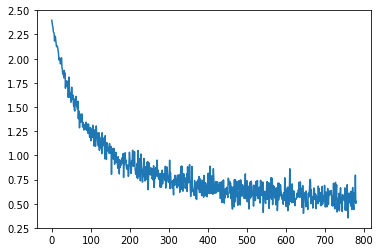

In [22]:
plt.plot(losses)

In [23]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)
        
    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [24]:
model = Mnist_NN().cuda()

In [25]:
losses = [update(x,y,lr) for x,y in data.train_dl]

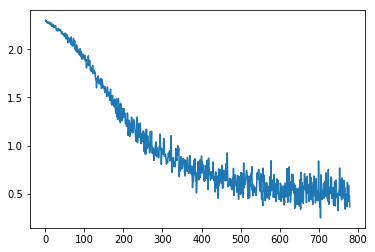

In [26]:
plt.plot(losses)

In [27]:
model = Mnist_NN().cuda()

In [28]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [29]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

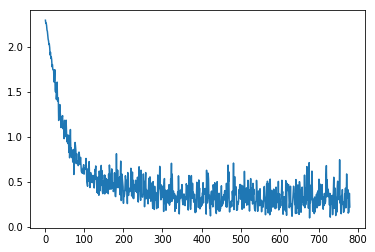

In [30]:
plt.plot(losses)

In [31]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


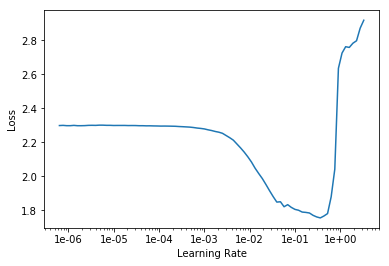

In [33]:
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.146285,0.135639,0.962400,00:05


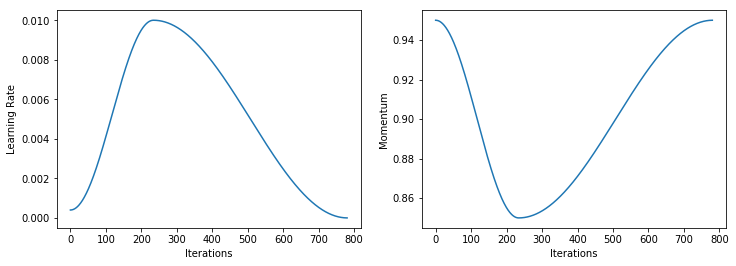

In [35]:
learn.recorder.plot_lr(show_moms=True)

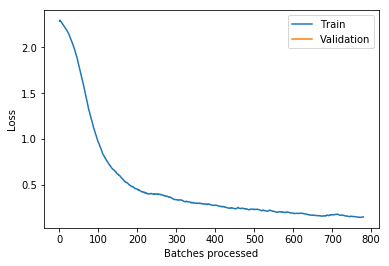

In [36]:
learn.recorder.plot_losses()